### Model Order Selection Figure

How do you know to use u', u'', u''', etc for the LHS term?


In [1]:
%load_ext autoreload
%autoreload 2

# Import Python packages
import pickle

# Third-Party Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Package Imports
from sindy_bvp import SINDyBVP
from sindy_bvp.differentiators import FiniteDifferences

In [2]:
# Set file to load
load_stem = "./data/S4-EB-"

In [3]:
%%time

# Set number of trials to use
num_trials = 100
diff_orders = list(range(1,7))

# Create an empty results list
results = []

print("Completed:", end=" ")
for i in diff_orders:
    # Create outcome variable string
    if i == 1:
        outcome_var = 'du/dx'
    else:
        outcome_var = 'd^{{{}}}u/dx^{{{}}}'.format(i, i)

    
    # Initialize SINDyBVP object
    sbvp = SINDyBVP(file_stem = load_stem,
                    num_trials = num_trials,
                    differentiator = FiniteDifferences(diff_order=i),
                    outcome_var = outcome_var,
                    noisemaker = None,
                    known_vars = None,
                    dep_var_name = 'u',
                    ind_var_name = 'x')

    # Execute the optimization
    coeffs, plotter = sbvp.sindy_bvp()

    # Compute the S-L coeffs with Plotter analysis tool
    try:
        plotter.compute_sl_coeffs()
        p = plotter.inferred_phi
        q = plotter.inferred_q
    except:
        p = None
        q = None
    
    # gather the learned coefficients and relevant metrics
    # And place into the results_list
    results.append({'outcome_var': outcome_var,
                    'p': p, 
                    'q': q,
                    'coeffs': coeffs})
    
    print(outcome_var, end=" | ")

Completed: du/dx | d^{2}u/dx^{2} | d^{3}u/dx^{3} | d^{4}u/dx^{4} | d^{5}u/dx^{5} | d^{6}u/dx^{6} | CPU times: user 15min 20s, sys: 5min 56s, total: 21min 17s
Wall time: 14min 19s


In [4]:
# Gather some testing data that SINDy-BVP did not see in training
# Load in the same data used above
ode_sols = pickle.load(open(load_stem + "sols.pickle", "rb"))
forcings = pickle.load(open(load_stem + "fs.pickle", "rb"))
# Split it, using the same random state as above
sol_train, sol_test, f_train, f_test = train_test_split(ode_sols,
                                                        forcings,
                                                        train_size=num_trials,
                                                        random_state=0)

# Use the build_dataframes method from most recent SINDy-BVP instance to create data pools
test_dfs = sbvp.build_dataframes(sol_test, f_test)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
losses = []

tf_cf = []

for result in results:
    coeffs = result["coeffs"]
    lhs_term = result["outcome_var"]
    if 'f' not in coeffs:
        losses.append(1)
        continue
    # compute phi
    phi = 1/coeffs['f']
    # enumerate the other operator coefficients
    operator_coeffs={}
    for term in coeffs:
        if term is not 'f':
            operator_coeffs[term] = -1*np.multiply(phi,coeffs[term])
    operator_coeffs[lhs_term] = phi.copy()
    # compute losses
    loss = 0
    tf_cf_entry =[]
    for test_df in test_dfs:
        true_f = test_df['f']
        computed_f = np.zeros(true_f.shape)
        for term in operator_coeffs:
            computed_f += np.multiply(operator_coeffs[term],test_df[term])
        diff = true_f - computed_f
        loss += np.linalg.norm(diff)/np.linalg.norm(true_f)
        tf_cf_entry.append((true_f,computed_f))
    tf_cf.append(tf_cf_entry)
    losses.append(loss/len(test_dfs))

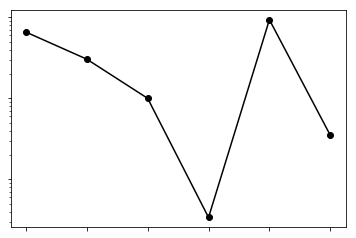

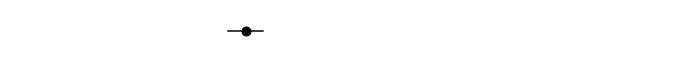

In [6]:
import matplotlib as mpl
mpl.rcParams["legend.markerscale"] = 1.5
mpl.rcParams["legend.labelspacing"] = 1.2
mpl.rcParams["legend.handlelength"] = 3.5
mpl.rcParams["legend.handletextpad"] = 20

figsize = (6,4)
# Create figure
plt.figure(figsize=figsize)
# set axes
ax1 = plt.gca()
# Plot the results
plt.semilogy(diff_orders, losses, '-o', color='k')

# Place the legend
lines = ax1.get_lines()
labels = [line.get_label() for line in lines]
labels = ['' for line in lines]

# Turn off all the tick labels
ax1.tick_params(labelbottom=False, labelleft=False)

# Save figure
plt.savefig('./Figs/Fig6-modelselection-EB.svg', dpi=600, transparent=True)

# Create separate axes
legend_figsize = (figsize[0]*2, figsize[1]/5)
plt.figure(figsize=legend_figsize)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
plt.legend(lines, labels, ncol=2, loc='center', frameon=False)
plt.savefig('./Figs/Fig6-legend.svg', dpi=600, transparent=True)


plt.show()

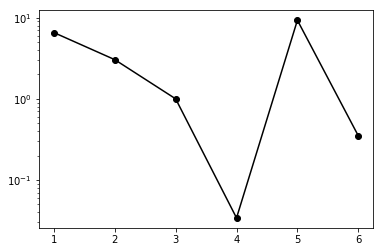

In [7]:
import matplotlib as mpl
mpl.rcParams["legend.markerscale"] = 1.5
mpl.rcParams["legend.labelspacing"] = 1.2
mpl.rcParams["legend.handlelength"] = 3.5
mpl.rcParams["legend.handletextpad"] = 20

figsize = (6,4)
# Create figure
plt.figure(figsize=figsize)
# set axes
ax1 = plt.gca()
# Plot the results
plt.semilogy(diff_orders, losses, '-o', color='k')

# Place the legend
lines = ax1.get_lines()
labels = [line.get_label() for line in lines]
labels = ['' for line in lines]

plt.show()